In [1]:
import numpy as np
from typing import List, Tuple
from sum_func import get_kvc_size, get_latency, load_datasets
from piecewise_func import PiecewiseLinear

default_model_name="meta-llama/Meta-Llama-3-8B"
default_cuda_device_name="NVIDIA RTX A5000"
data_content='conv'

dataset_frame = load_datasets(_dataset_content = data_content)
kvc_size_in_gb = get_kvc_size(default_model_name)

piecewise_func_list = []

for index, request in dataset_frame.iterrows():
    start_timestamp = dataset_frame.loc[index, 'TIMESTAMP']
    prompt_len = dataset_frame.loc[index, 'ContextTokens']
    response_len = dataset_frame.loc[index, 'GeneratedTokens']
    prompt_latency, response_latency, total_latency=get_latency(
        _model_name = default_model_name,
        _cuda_device_name = default_cuda_device_name,
        _prompt_length = prompt_len,
        _response_length = response_len
    )

    piecewise_func_instance = PiecewiseLinear(
        start_x=start_timestamp,
        prompt_mem = kvc_size_in_gb * prompt_len,
        prompt_latency = prompt_latency,
        total_mem = kvc_size_in_gb * (prompt_len + response_len),
        total_latency = total_latency
        )
    
    piecewise_func_list.append(piecewise_func_instance)

For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_bw: 460.8 GB/s, for model: meta-llama/Meta-Llama-3-8B, kvc_size: 512.0 KB, ptps=5498.5 tokens/s
For gpu: NVIDIA RTX A5000, practical_mem_

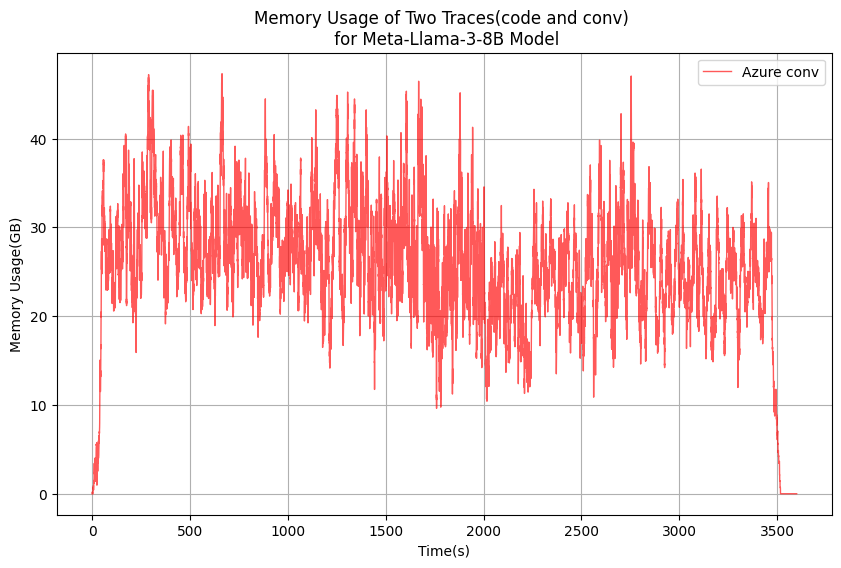

In [2]:
from matplotlib import pyplot as plt
def generate_uniform_interpolation_points(start: float, end: float, points_per_second: int) -> np.ndarray:
    total_points = (end - start) * points_per_second
    return np.linspace(start, end, int(total_points))

interpolation_points = generate_uniform_interpolation_points(0, 3600, 10)

def sum_all_pw(pws: List[PiecewiseLinear]) -> Tuple[List[float], List[float]]:
    timestamp_list = []
    mem_list = []
    for interpolation_point in interpolation_points:
        cur_sum = 0
        for pw in pws:
            cur_sum += pw.interpolate(interpolation_point)
        
        timestamp_list.append(interpolation_point)
        mem_list.append(cur_sum)
        
    return (timestamp_list, mem_list)
            
result = sum_all_pw(piecewise_func_list)

def plot_sum_interpolation(_result_tuple, _model_name):
    plt.figure(figsize=(10, 6)) 
    model_parts=_model_name.split('/')
    #model_prefix=model_parts[0]
    model_suffix=model_parts[-1]
    
    timestamps = _result_tuple[0]
    mem_consumption = _result_tuple[1]
    
    plt.plot(timestamps, mem_consumption, label=f'Azure {data_content}', color='red', alpha=0.65, linewidth=1)
    #plt.plot(x_fine_code, y_fine_code, label='Azure code', color='blue', alpha=0.65, linewidth=1)
    plt.xlabel('Time(s)')
    plt.ylabel('Memory Usage(GB)')
    plt.title(f'Memory Usage of Two Traces(code and conv) \n for {model_suffix} Model')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'./plots/{model_name}/pwlinear_sum_comparison.png')
    plt.show()
        
plot_sum_interpolation(_result_tuple = result, _model_name = default_model_name)
        